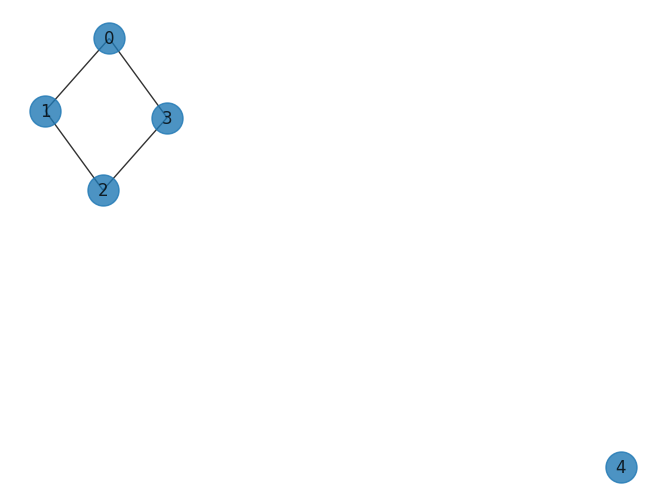

In [10]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3, 4])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

[[0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 0.]]


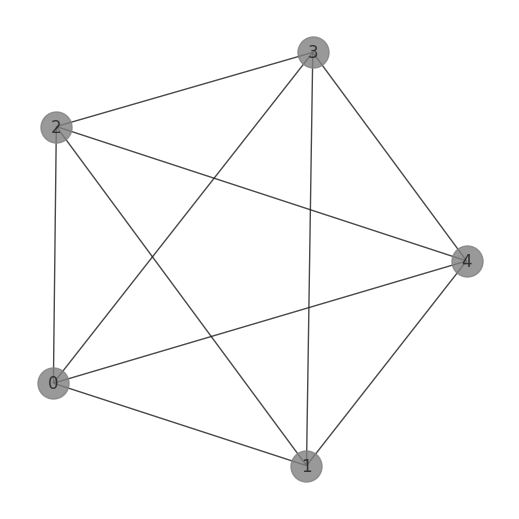

In [129]:
#G = nx.random_regular_G(4, 5)
G = nx.Graph()
figure = plt.figure(figsize=(5, 5))
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0),(0, 4), (1, 4), (2, 4), (3, 4),(0, 2), (1, 3)])
# print the adjacency matrix of the G
print(nx.to_numpy_matrix(G))
nx.draw(G, with_labels=True, alpha=0.8, node_size=500, node_color='gray')

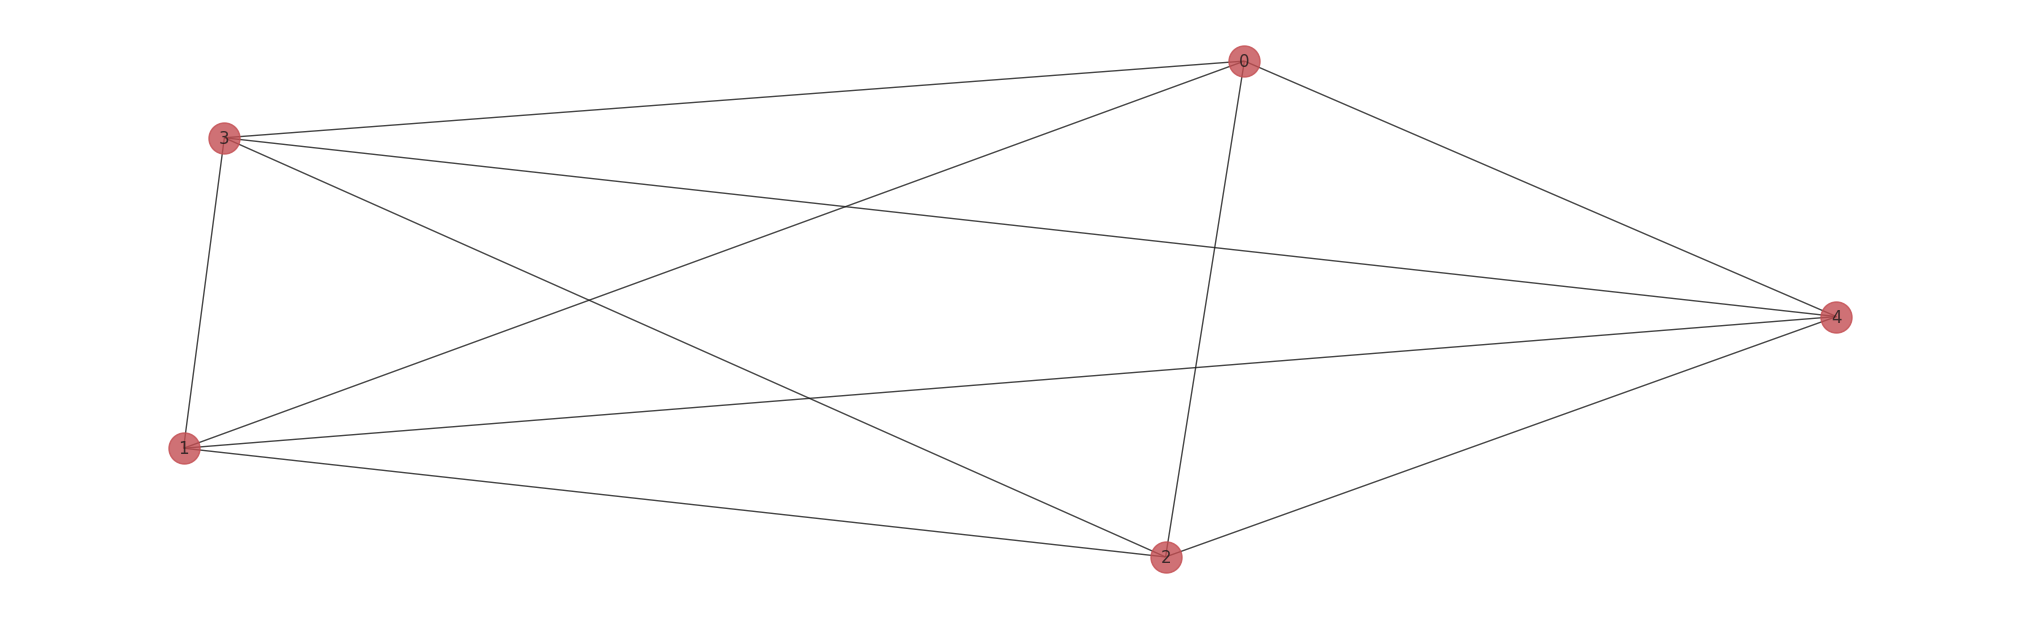

In [127]:
nx.draw(G, with_labels=True, alpha=0.8, node_size=500, node_color='r')

In [2]:
import quimb.tensor as qtn
import numpy as np

# Define the number of qubits and number of layers
n = 4
p = 2

# Define the cost function as a list of pauli_terms
terms = [
    (0.5, 'ZI'),
    (0.5, 'IZ'),
    (0.5, 'ZZ'),
    (0.5, 'YY'),
]

# Define the QAOA circuit using circ_qaoa
gammas = np.random.randn(p)
betas = np.random.randn(p)
circ = qtn.circ_qaoa(terms, p, gammas, betas)

# Sample 100 bitstrings from the QAOA circuit using the default sampling method
samples = circ.sample(n=100)

print(samples)


TypeError: '>' not supported between instances of 'str' and 'float'

In [17]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

N_QUBITS = 5

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS )
for i in range(0, N_QUBITS ):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

/tmp/ipykernel_9284/133521271.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


┌───────────────┐
q_0: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_1: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_2: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_3: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_4: ┤ Rx(2*$\beta$) ├
     └───────────────┘

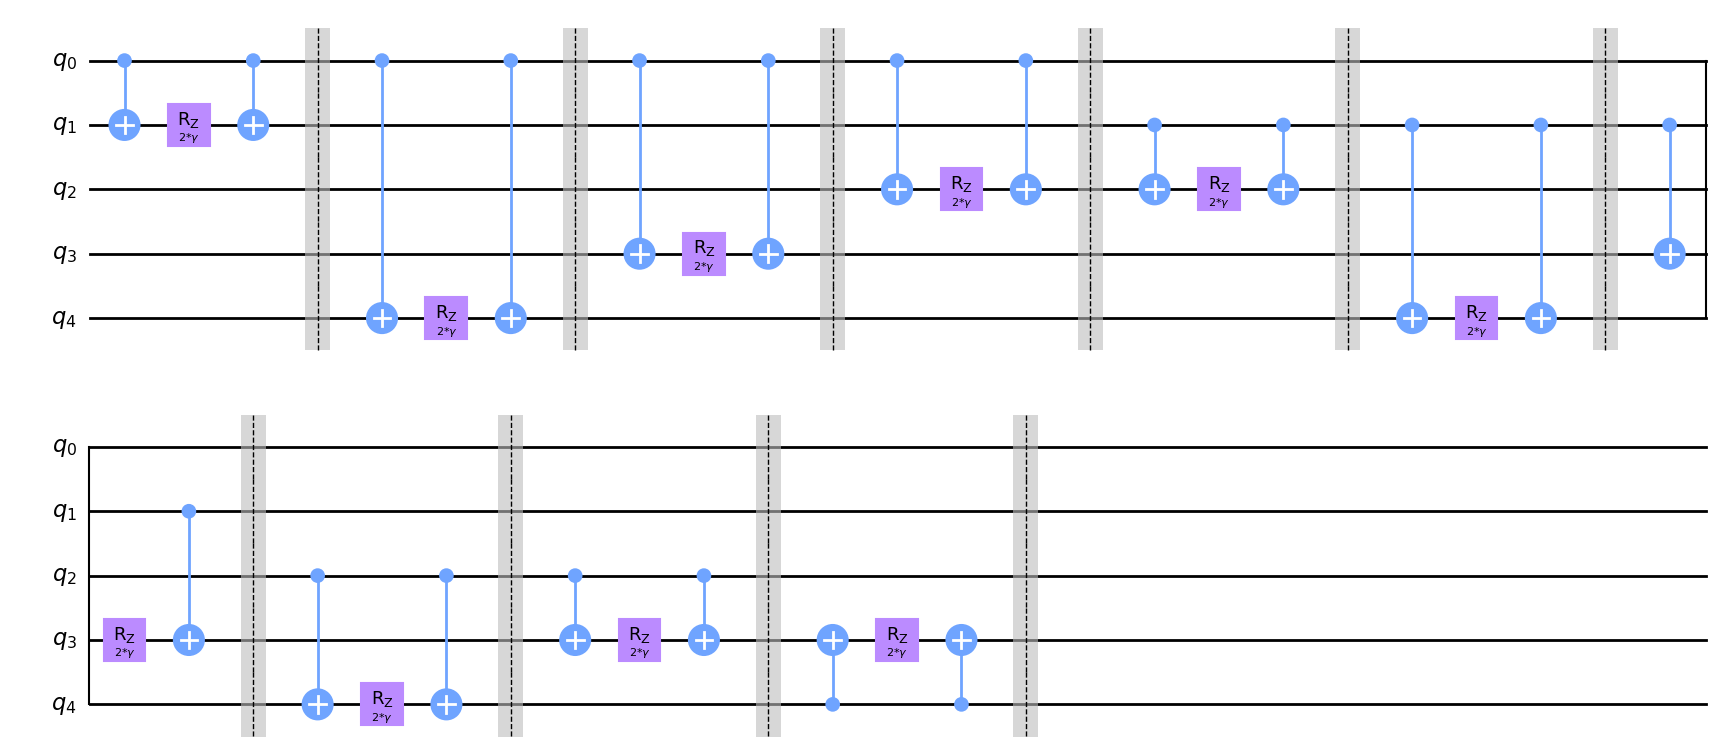

In [18]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw('mpl')

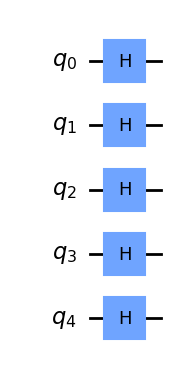

In [19]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw('mpl')

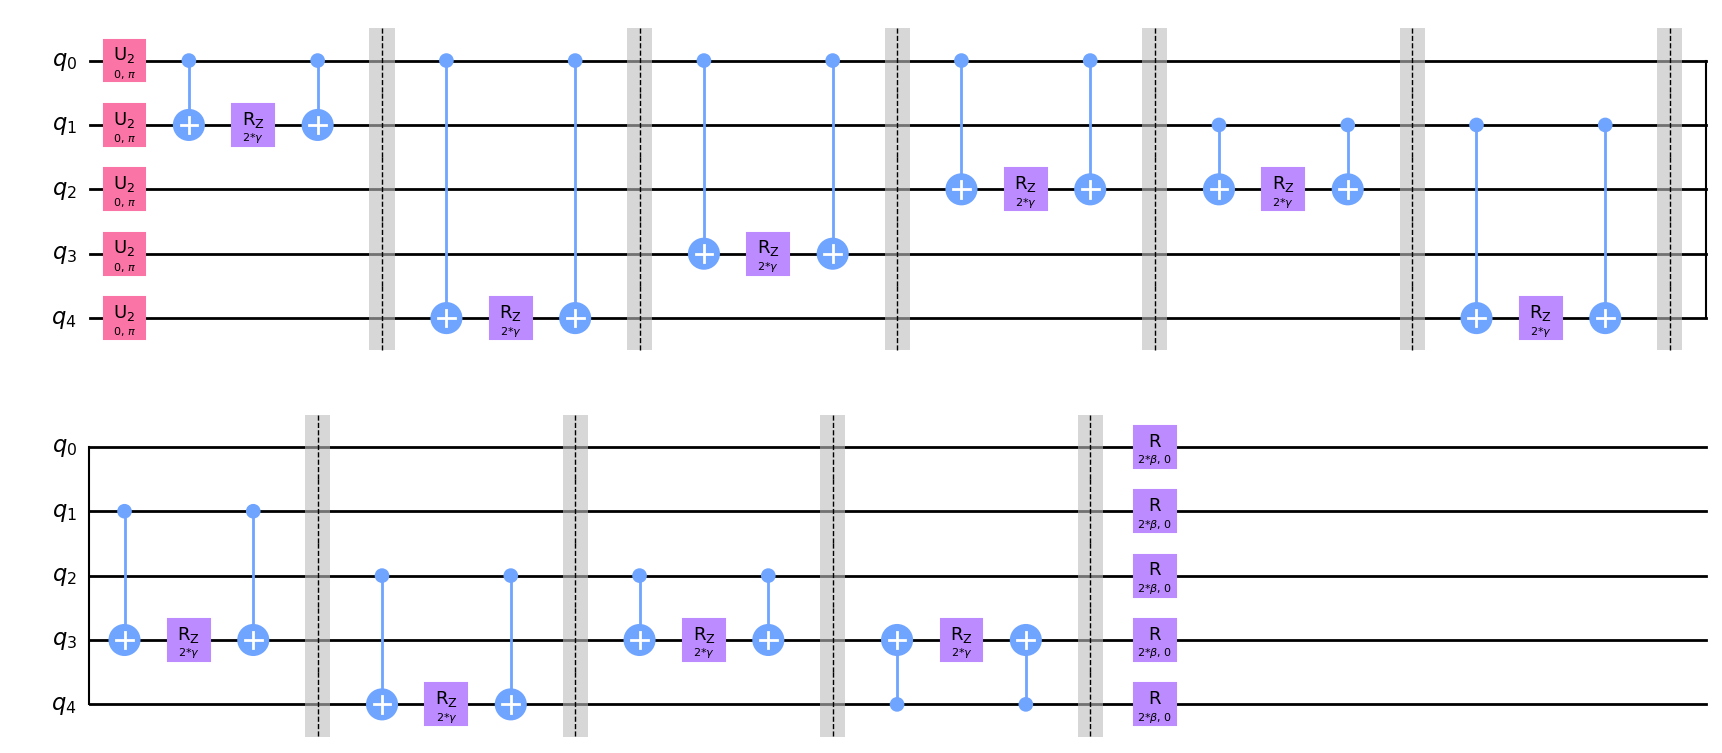

In [20]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw('mpl')

In [136]:
theta

NameError: name 'theta' is not defined

In [7]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [141]:
from scipy.optimize import minimize
expectation = get_expectation(G)
res = minimize(expectation,
               [1.0,1.0,1.0, 1.0],
               method='COBYLA')
print(res)

     fun: -5.982421875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 53
  status: 1
 success: True
       x: array([1.04002875, 0.97430523, 1.00792504, 1.10944869])


In [145]:
from scipy.optimize import minimize
expectation = get_expectation(G)
res = minimize(expectation,
               [1.0,1.0,1.0, 1.0,1,1,1,1,1,1,1,1,1,1,1,1,1],
               method='COBYLA')
res

     fun: -5.982421875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 145
  status: 1
 success: True
       x: array([0.91954935, 1.00976519, 1.03968729, 0.99744306, 1.04753728,
       0.98669078, 1.03343193, 0.98577843, 0.97701262, 1.06029588,
       0.93119574, 1.98637237, 1.01984741, 1.99935579, 0.99845721,
       1.11715612, 0.99908461])

In [133]:
res_n

 final_simplex: (array([[1.83115234, 1.36611328],
       [1.83108892, 1.36608553],
       [1.83110313, 1.36605415]]), array([-5.9140625, -5.9140625, -5.9140625]))
           fun: -5.9140625
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 32
        status: 0
       success: True
             x: array([1.83115234, 1.36611328])

In [134]:
res_p

   direc: array([[0.        , 1.        ],
       [0.2353541 , 0.10321879]])
     fun: array(-5.9140625)
 message: 'Optimization terminated successfully.'
    nfev: 217
     nit: 3
  status: 0
 success: True
       x: array([1.84024649, 1.36754357])

In [135]:
res_l

      fun: -2.09765625
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1., 1.])

In [48]:
res_n = minimize(expectation,
               [1.0, 1.0],
               method='Nelder-Mead')

In [49]:
res_p = minimize(expectation,
               [1.0, 1.0],
               method='Powell')

In [56]:
res_l = minimize(expectation,
               [1.0, 1.0],
               method='L-BFGS-B')

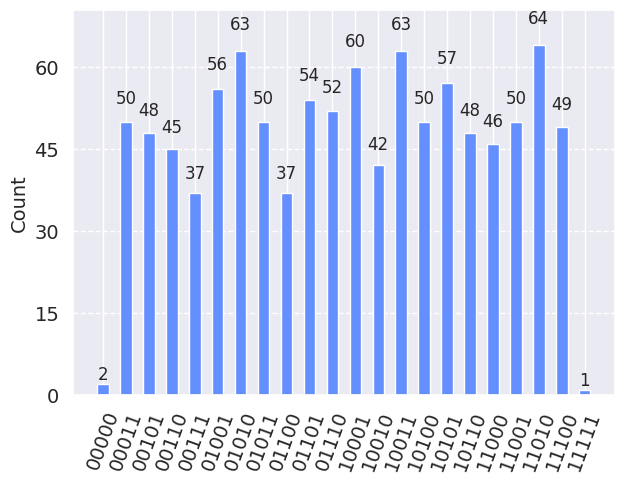

In [146]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

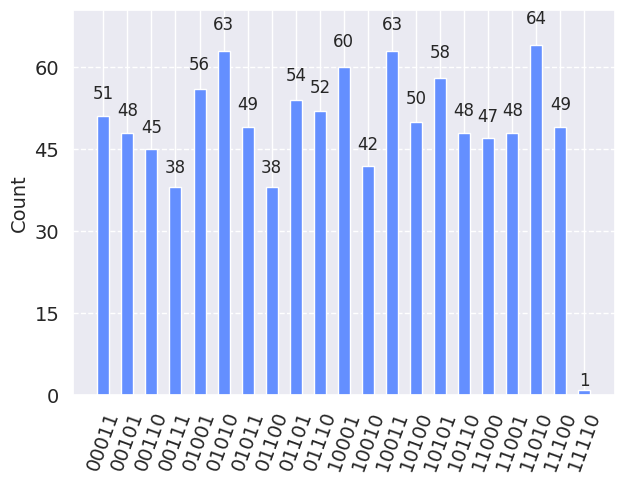

In [140]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

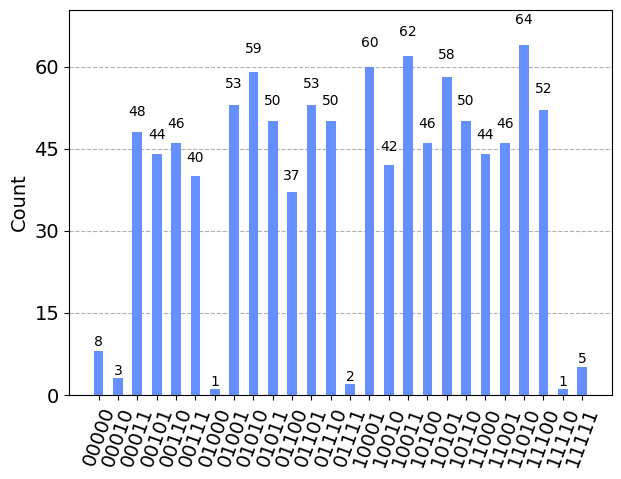

In [22]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

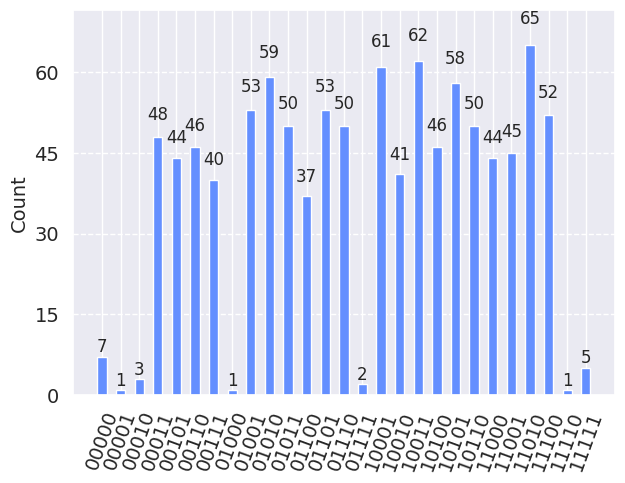

In [30]:
qc_res_n = create_qaoa_circ(G, res_n.x)
counts_n = backend.run(qc_res_n, seed_simulator=10).result().get_counts()
plot_histogram(counts_n)

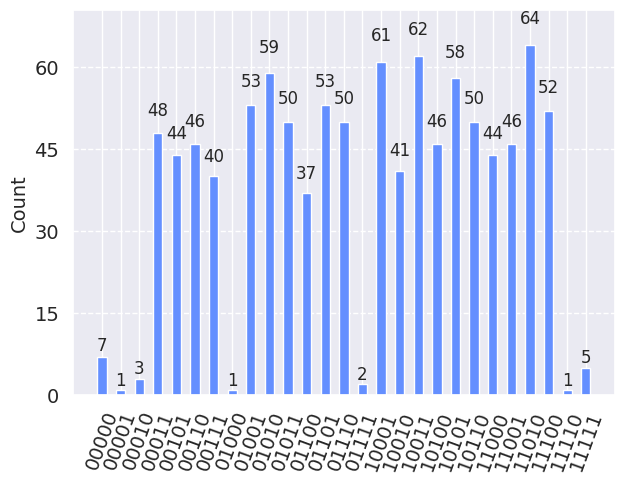

In [58]:
qc_res_p = create_qaoa_circ(G, res_p.x)
counts_p = backend.run(qc_res_p, seed_simulator=10).result().get_counts()
plot_histogram(counts_p)

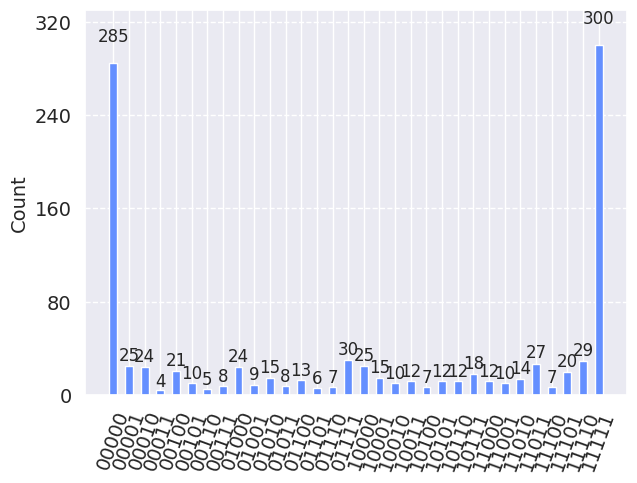

In [59]:
qc_res_l = create_qaoa_circ(G, res_l.x)
counts_l = backend.run(qc_res_l, seed_simulator=10).result().get_counts()
plot_histogram(counts_l)

In [108]:
counts_n[list(counts_l.keys())[32]]

IndexError: list index out of range

In [75]:
list(counts_l.keys())[0]

'00011'

In [109]:
counts_l = {'00011': 4, '01101': 6, '10010': 10, '11000': 12, '10101': 12, '11100': 7, '10110': 12, '01111': 30, '01011': 8, '11111': 300,  '11110': 29, '00111': 8, '01110': 7, '01100': 13, '01000': 24, '00001': 25, '00110': 5,  '10100': 7, '10001': 15, '11010': 14, '00101': 10, '01001': 9, '00000': 285, '11001': 10, '00010': 24, '01010': 15, '10011': 12}

In [39]:
counts['00001'] = 0
# how to append a new key to a dictionary
#d = {'a': 1, 'b': 2}
#d['c'] = 3
#print(d)

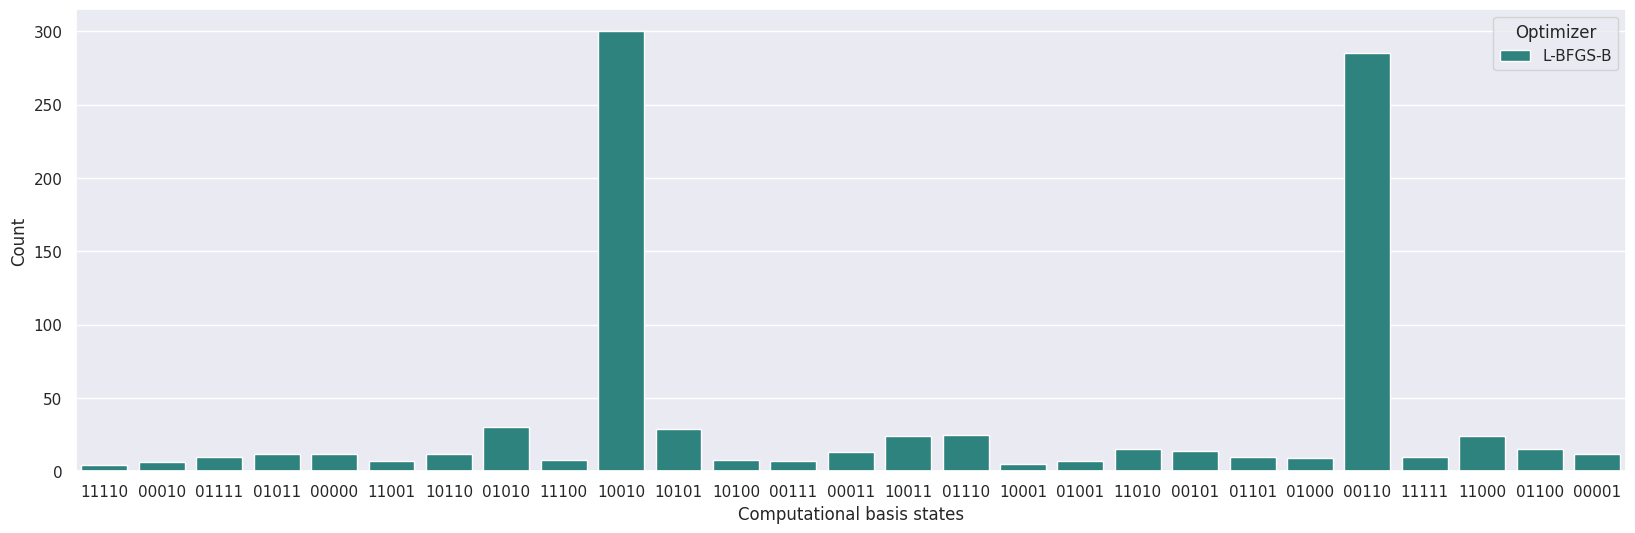

In [131]:

# Create a DataFrame from the dictionaries
df = pd.DataFrame({'Bitstring': list(counts.keys()),  'L-BFGS-B': list(counts_l.values())})

# Melt the DataFrame to "long" format
df_melted = df.melt(id_vars='Bitstring', var_name='Optimizer', value_name='Count')

# Set the size of the plot
sns.set(rc={'figure.figsize':(20,6)})

# Plot the barplot
sns.barplot(data=df_melted, x='Bitstring', y='Count', hue='Optimizer', palette='viridis', width=0.8)

# Add axis labels and a title
plt.xlabel('Computational basis states')
plt.ylabel('Count')
#plt.title('Histogram of Counts for Two Datasets')

# Add a legend
plt.legend(title='Optimizer')

# Display the plot
plt.show()

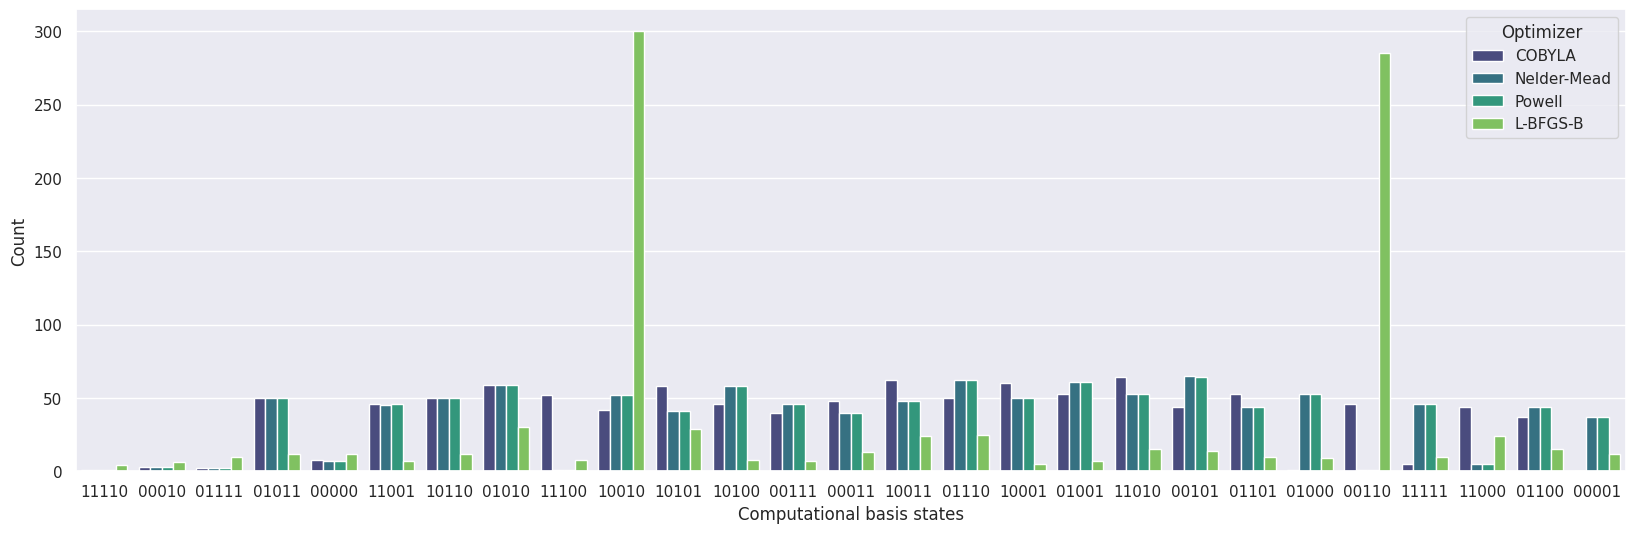

In [117]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt


# Create a DataFrame from the dictionaries
df = pd.DataFrame({'Bitstring': list(counts.keys()), 'COBYLA': list(counts.values()),'Nelder-Mead': list(counts_n.values()),'Powell': list(counts_p.values()), 'L-BFGS-B': list(counts_l.values())})

# Melt the DataFrame to "long" format
df_melted = df.melt(id_vars='Bitstring', var_name='Optimizer', value_name='Count')

# Set the size of the plot
sns.set(rc={'figure.figsize':(20,6)})

# Plot the barplot
sns.barplot(data=df_melted, x='Bitstring', y='Count', hue='Optimizer', palette='viridis', width=0.8)

# Add axis labels and a title
plt.xlabel('Computational basis states')
plt.ylabel('Count')
#plt.title('Histogram of Counts for Two Datasets')

# Add a legend
plt.legend(title='Optimizer')

# Display the plot
plt.show()

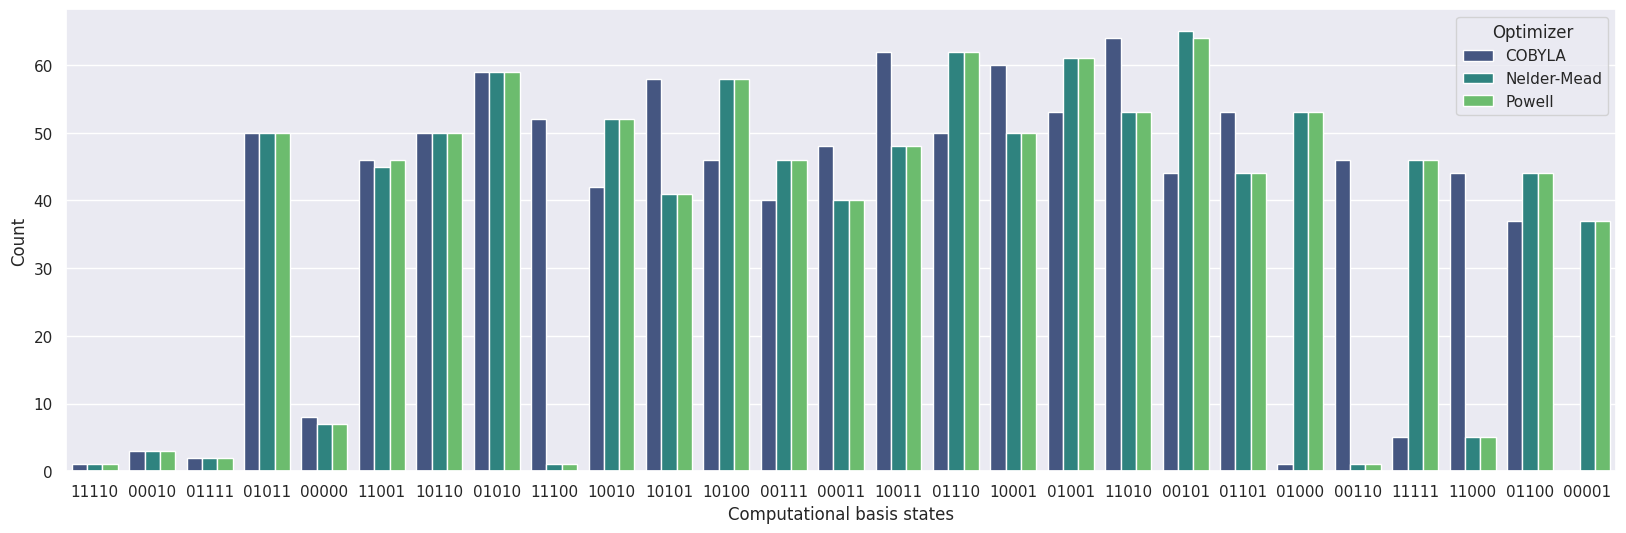

In [130]:

# Create a DataFrame from the dictionaries
df = pd.DataFrame({'Bitstring': list(counts.keys()), 'COBYLA': list(counts.values()),'Nelder-Mead': list(counts_n.values()),'Powell': list(counts_p.values())})

# Melt the DataFrame to "long" format
df_melted = df.melt(id_vars='Bitstring', var_name='Optimizer', value_name='Count')

# Set the size of the plot
sns.set(rc={'figure.figsize':(20,6)})

# Plot the barplot
sns.barplot(data=df_melted, x='Bitstring', y='Count', hue='Optimizer', palette='viridis', width=0.8)

# Add axis labels and a title
plt.xlabel('Computational basis states')
plt.ylabel('Count')
#plt.title('Histogram of Counts for Two Datasets')

# Add a legend
plt.legend(title='Optimizer')

# Display the plot
plt.show()